# Course Project (DA311 Machine Learning Lab)

By:-

- Aryan Gupta (230150003)
- Tejas Deshmukh (230150027)


# Traffic Sign Recognition Based on HOG Feature and SVM

This notebook implements a method inspired by [_"Traffic Sign Recognition Based on HOG Feature and SVM"_ (Tang et al.)](https://dl.acm.org/doi/10.1145/3443467.3443811). The pipeline uses the [GTSRB dataset](https://benchmark.ini.rub.de/gtsrb_dataset.html) and includes visualizations for each step, hyperparameter experiments, cross-validation, timing analysis, and error analysis.


## Installing Libraries


In [1]:
import os # for file operations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 # OpenCV for image processing
from sklearn.svm import SVC # Support Vector Classifier

# analysis
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import joblib # for saving/loading models
import time # for timing

import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded. OpenCV version:', cv2.__version__)


Libraries loaded. OpenCV version: 4.11.0


## Load dataset

Instructions to load have been provided on the dataset website.


In [2]:
TRAIN_DIR = 'GTSRB_Final_Training_Images/GTSRB/Final_Training/Images'

In [3]:
# the below is according to the dataset website
def load_gtsrb(train_dir=TRAIN_DIR, limit_per_class=None):
    images = []
    labels = []
    
    # class folders
    classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    print(f'Found {len(classes)} class folders.')
    
    for class_id in classes:
        print('\n'+'='*60)
        print(f'Loading class {class_id}...')
        
        folder = os.path.join(train_dir, class_id)
        csv_path = os.path.join(folder, f'GT-{class_id}.csv')
        
        if not os.path.exists(csv_path):
            print(f'CSV file not found for class {class_id}, loading all images in folder.')
            
            files = sorted([f for f in os.listdir(folder) if f.lower().endswith('.ppm')])
            
            for i, fname in enumerate(files):
                # Respect limit per class if specified
                if limit_per_class and i >= limit_per_class:
                    break
                
                # Read image
                img = cv2.imread(os.path.join(folder, fname))
                if img is None:
                    continue
                images.append(img)
                labels.append(int(class_id))
                
                # give progress
                if (i+1) % 150 == 0:
                    print(f'Loaded {i+1} images for class {class_id}...')
                    
            # no need to read later code
            continue
        
        print(f'Loading from CSV: {csv_path}')
        df = pd.read_csv(csv_path, sep=';')
        count = 0 # for image count per class
        for _, row in df.iterrows():
            filepath = os.path.join(folder, row['Filename'])
            
            # Read image
            img = cv2.imread(filepath)
            if img is None:
                continue
            images.append(img)
            labels.append(int(row['ClassId']))
            count += 1
            
            # give progress
            if count % 150 == 0:
                print(f'Loaded {count} images for class {class_id}...')
                
            # Respect limit per class if specified
            if limit_per_class and count >= limit_per_class:
                break
            
    return images, labels

In [4]:
# Warning: For full dataset, set limit_per_class=None. For quick debugging, set a small integer.
start_time = time.time()
images, labels = load_gtsrb(limit_per_class=None)
# images, labels = load_gtsrb(limit_per_class=1)
end_time = time.time()

print('Loaded images:', len(images), 'labels:', len(labels))
print(f'Time taken to load dataset: {end_time - start_time:.2f} seconds')

Found 43 class folders.

Loading class 00000...
Loading from CSV: GTSRB_Final_Training_Images/GTSRB/Final_Training/Images\00000\GT-00000.csv
Loaded 150 images for class 00000...

Loading class 00001...
Loading from CSV: GTSRB_Final_Training_Images/GTSRB/Final_Training/Images\00001\GT-00001.csv
Loaded 150 images for class 00001...
Loaded 300 images for class 00001...
Loaded 450 images for class 00001...
Loaded 600 images for class 00001...
Loaded 750 images for class 00001...
Loaded 900 images for class 00001...
Loaded 1050 images for class 00001...
Loaded 1200 images for class 00001...
Loaded 1350 images for class 00001...
Loaded 1500 images for class 00001...
Loaded 1650 images for class 00001...
Loaded 1800 images for class 00001...
Loaded 1950 images for class 00001...
Loaded 2100 images for class 00001...

Loading class 00002...
Loading from CSV: GTSRB_Final_Training_Images/GTSRB/Final_Training/Images\00002\GT-00002.csv
Loaded 150 images for class 00002...
Loaded 300 images for cla

## Image Enhancement (YUV + CLAHE)

We convert images to YUV, apply CLAHE (adaptive histogram equalization) to the Y channel to improve contrast (especially for low-light images), and convert back.


In [5]:
def enhance_image(img):
    # Convert BGR->YUV, apply CLAHE on Y channel, then back to BGR.
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    Y, U, V = cv2.split(yuv)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    Y_eq = clahe.apply(Y)
    yuv_eq = cv2.merge((Y_eq, U, V))
    enhanced = cv2.cvtColor(yuv_eq, cv2.COLOR_YUV2BGR)
    return enhanced

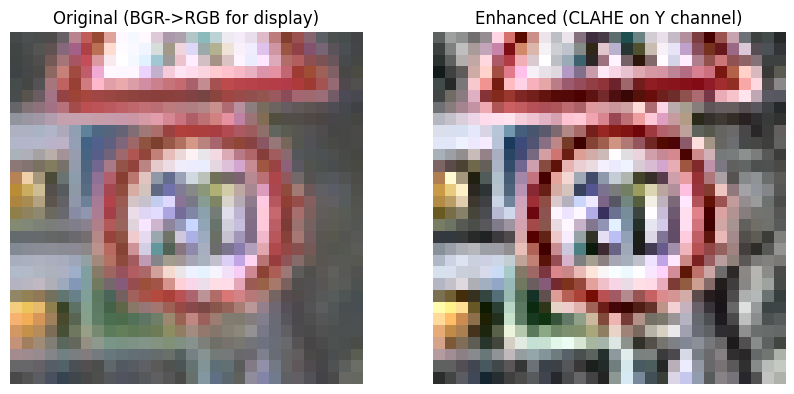

In [6]:
# Visualize an example
idx = 1
orig = images[idx]
enh = enhance_image(orig)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Original (BGR->RGB for display)')
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Enhanced (CLAHE on Y channel)')
plt.imshow(cv2.cvtColor(enh, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Color Segmentation (HSV masks)

Traffic signs commonly use red, blue, and yellow. We convert to HSV and threshold those ranges.


In [7]:
def segment_colors(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Red ranges (wrap-around)
    lower_red1 = np.array([0, 70, 50]); upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50]); upper_red2 = np.array([180, 255, 255])
    mask_red = cv2.inRange(hsv, lower_red1, upper_red1) | cv2.inRange(hsv, lower_red2, upper_red2)
    # Blue
    lower_blue = np.array([90, 70, 50]); upper_blue = np.array([130, 255, 255])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    # Yellow
    lower_yellow = np.array([15, 70, 50]); upper_yellow = np.array([35, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    mask = mask_red | mask_blue | mask_yellow
    segmented = cv2.bitwise_and(img, img, mask=mask)
    
    return mask, segmented

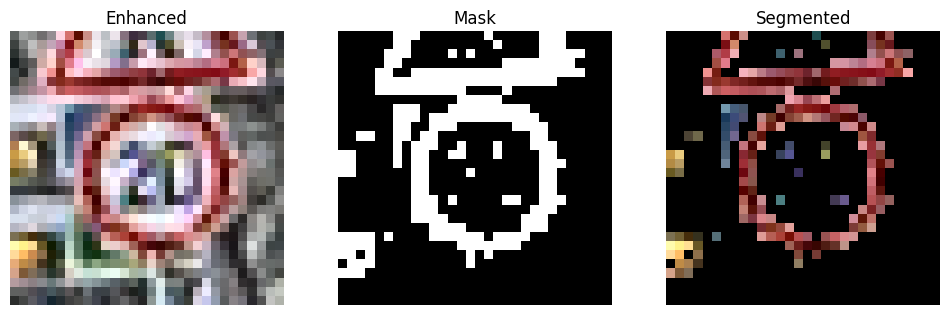

In [8]:
mask, seg = segment_colors(enh)

plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.title('Enhanced'); plt.imshow(cv2.cvtColor(enh, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1,3,2); plt.title('Mask'); plt.imshow(mask, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Segmented'); plt.imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()


## Shape Detection (Hough for circles + Contour approximation for polygons)


In [9]:
def detect_shapes(img, mask, debug=False):
    sign_regions = []
    
    # Preprocess mask for contours
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    m = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    # HoughCircles on grayscale image (use mask area to speed up)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    try:
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                                   param1=50, param2=30, minRadius=8, maxRadius=200)
        # might return error or none
    except Exception:
        circles = None
        
    if circles is not None:
        circles = np.uint16(np.round(circles))
        
        for x,y,r in circles[0]:
            x,y,r = int(x),int(y),int(r)
            
            # Crop circle region
            y0 = max(0, y-r); y1 = min(img.shape[0], y+r)
            x0 = max(0, x-r); x1 = min(img.shape[1], x+r)
            crop = img[y0:y1, x0:x1]
            
            sign_regions.append(crop)
            if debug:
                cv2.circle(img, (x,y), r, (0,255,0), 2)
                
    # Contours for polygons
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 100:  # skip tiny regions
            continue
        
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
        x,y,w,h = cv2.boundingRect(approx)
        
        # crop according to bounding box
        crop = img[y:y+h, x:x+w]
        sign_regions.append(crop)
        if debug:
            cv2.drawContours(img, [approx], -1, (255,0,0), 2)
            
    return sign_regions

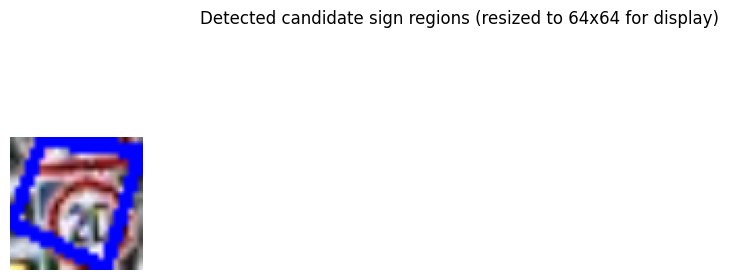

In [10]:
crops = detect_shapes(enh, mask, debug=True)

# show first few crops
plt.figure(figsize=(12,4))
for i, c in enumerate(crops[:6]):
    plt.subplot(1,6,i+1)
    plt.imshow(cv2.cvtColor(cv2.resize(c, (64,64)), cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.suptitle('Detected candidate sign regions (resized to 64x64 for display)')
plt.show()


## HOG Feature Extraction

This is the implementation of HOG using libraries.

HOG parameters: 64x64 images, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9


In [11]:
def extract_hog_features(img, visualize=False):
    """
    Parameters from paper:
    - Image size: 64x64
    - Cell size: 8x8 pixels
    - Block size: 2x2 cells (4 cells per block)
    - Orientations: 9 gradient directions
    - Feature dimension: 1764
    
    Args:
        img: Input image (BGR format)
        visualize: If True, return HOG visualization
    
    Returns:
        features: HOG feature vector
        hog_image (optional): Visualization of HOG features
    """
    # Convert to grayscale and resize to 64x64
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (64, 64))
    
    # Normalize
    resized = resized.astype(np.float32) / 255.0
    
    # Calculate gradients using formulas (8) and (9) from paper
    # Gx(x,y) = I(x+1,y) - I(x-1,y)
    # Gy(x,y) = I(x,y+1) - I(x,y-1)
    gx = np.zeros_like(resized)
    gy = np.zeros_like(resized)
    
    # Horizontal gradient
    gx[:, 1:-1] = resized[:, 2:] - resized[:, :-2]
    
    # Vertical gradient
    gy[1:-1, :] = resized[2:, :] - resized[:-2, :]
    
    # Calculate gradient magnitude and direction using formulas (10) and (11)
    # G(x,y) = sqrt(Gx^2 + Gy^2)
    # α(x,y) = arctan(Gy/Gx)
    magnitude = np.sqrt(gx**2 + gy**2)
    direction = np.arctan2(gy, gx)  # Returns angle in radians [-π, π]
    
    # Convert direction to degrees [0, 360)
    direction = np.degrees(direction) % 360
    
    # Parameters from paper
    cell_size = 8  # Cw = Ch = 8
    block_size = 2  # B = 4 cells (2x2)
    num_bins = 9   # H = 9 orientations
    
    # Divide image into cells and compute histogram for each cell
    num_cells_x = resized.shape[1] // cell_size  # 64/8 = 8
    num_cells_y = resized.shape[0] // cell_size  # 64/8 = 8
    
    # Initialize cell histograms
    cell_histograms = np.zeros((num_cells_y, num_cells_x, num_bins))
    
    # Compute histogram for each cell
    bin_width = 360.0 / num_bins  # 40 degrees per bin
    
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            # Extract cell region
            cell_mag = magnitude[i*cell_size:(i+1)*cell_size, 
                                j*cell_size:(j+1)*cell_size]
            cell_dir = direction[i*cell_size:(i+1)*cell_size, 
                                j*cell_size:(j+1)*cell_size]
            
            # Build histogram using bilinear interpolation
            for y in range(cell_size):
                for x in range(cell_size):
                    mag = cell_mag[y, x]
                    angle = cell_dir[y, x]
                    
                    # Find the two nearest bins
                    bin_idx = angle / bin_width
                    bin_low = int(np.floor(bin_idx)) % num_bins
                    bin_high = int(np.ceil(bin_idx)) % num_bins
                    
                    # Bilinear interpolation weights
                    weight_high = bin_idx - np.floor(bin_idx)
                    weight_low = 1.0 - weight_high
                    
                    # Accumulate weighted magnitude
                    cell_histograms[i, j, bin_low] += mag * weight_low
                    cell_histograms[i, j, bin_high] += mag * weight_high
    
    # Block normalization (L2-Hys normalization)
    # Formula (12): N = (Iw/Cw - 1) × (Ih/Ch - 1) × B × H
    # N = (64/8 - 1) × (64/8 - 1) × 4 × 9 = 7 × 7 × 36 = 1764
    
    num_blocks_x = num_cells_x - (block_size - 1)  # 8 - 1 = 7
    num_blocks_y = num_cells_y - (block_size - 1)  # 8 - 1 = 7
    
    feature_vector = []
    
    # For visualization
    if visualize:
        hog_image = np.zeros((num_cells_y * cell_size, num_cells_x * cell_size))
    
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            # Extract block (2x2 cells = 4 cells)
            block = cell_histograms[i:i+block_size, j:j+block_size, :].flatten()
            
            # L2-Hys normalization
            # 1. L2 normalization
            norm = np.sqrt(np.sum(block**2) + 1e-6)
            block = block / norm
            
            # 2. Clip values
            block = np.clip(block, 0, 0.2)
            
            # 3. Renormalize
            norm = np.sqrt(np.sum(block**2) + 1e-6)
            block = block / norm
            
            feature_vector.extend(block)
    
    features = np.array(feature_vector)
    
    # Verify feature dimension matches paper
    assert len(features) == 1764, f"Feature dimension should be 1764, got {len(features)}"
    
    if visualize:
        # Create HOG visualization
        for i in range(num_cells_y):
            for j in range(num_cells_x):
                # Get cell histogram
                hist = cell_histograms[i, j, :]
                
                # Draw orientation bars
                cx = (j + 0.5) * cell_size
                cy = (i + 0.5) * cell_size
                
                for k in range(num_bins):
                    angle = (k * bin_width + bin_width / 2) * np.pi / 180.0
                    magnitude_val = hist[k]
                    
                    # Draw line representing gradient orientation
                    # dx = np.cos(angle) * cell_size / 2
                    # dy = np.sin(angle) * cell_size / 2
                    dx = magnitude_val * np.cos(angle) * cell_size / 2
                    dy = magnitude_val * np.sin(angle) * cell_size / 2
                    
                    x1 = int(cx - dx)
                    y1 = int(cy - dy)
                    x2 = int(cx + dx)
                    y2 = int(cy + dy)
                    
                    cv2.line(hog_image, (x1, y1), (x2, y2), 
                            magnitude_val * 255, thickness=1)
        
        # Normalize visualization for display
        hog_image = (hog_image - hog_image.min()) / (hog_image.max() - hog_image.min() + 1e-6)
        
        return features, hog_image
    else:
        return features

Visualise for one image


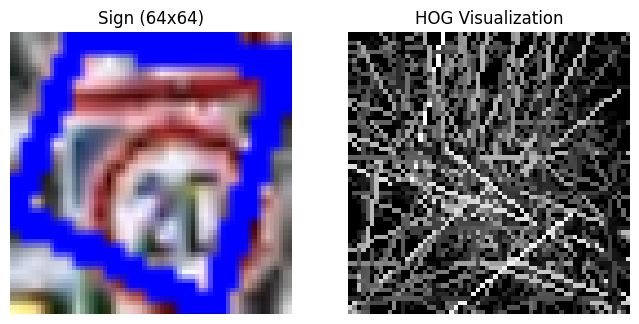

In [12]:
# Visualize HOG for first detected crop (if any)
if len(crops) > 0:
    feat, hog_vis = extract_hog_features(crops[0], visualize=True)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.title('Sign (64x64)'); plt.imshow(cv2.cvtColor(cv2.resize(crops[0], (64,64)), cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.subplot(1,2,2); plt.title('HOG Visualization'); plt.imshow(hog_vis, cmap='gray'); plt.axis('off')
    plt.show()
else:
    print('No crops detected for HOG visualization.')

## Build Full pipeline

Now we process all training images: enhance → segment → detect → choose best candidate (if multiple) → extract HOG


### Command Centre


In [13]:
run_full_extraction = True  # <-- Set to True if you want to run extraction on the full dataset
train_initial_model = True  # <-- Set to True to enable initial training and evaluation rbf kernel and c=60
check_best_kernel = True  # <-- Set to True to check best kernel
cross_validate_best_kernel = True  # <-- Set to True to perform cross-validation on best kernel

# model save
save_model = True
model_path = 'svm_hog_gtsrb_rbf_c60_itr5.joblib'
load_model_and_predict = True
model_path_load = "svm_hog_gtsrb_rbf_c60_itr5.joblib"

In [14]:
# Function to process a single image and return a HOG vector (or None if not found)
def process_and_extract(img):
    enhanced = enhance_image(img)
    mask, seg = segment_colors(enhanced)
    regions = detect_shapes(enhanced, mask, debug=False)
    
    # If no region found, use center crop
    if len(regions) == 0:
        h,w = img.shape[:2]
        size = min(h,w)
        cy,cx = h//2, w//2
        half = size//2
        crop = img[max(0,cy-half):min(h,cy+half), max(0,cx-half):min(w,cx+half)]
        regions = [crop]
        
    # Choose the largest region by area (simple heuristic)
    best = max(regions, key=lambda x: x.shape[0]*x.shape[1])
    feat = extract_hog_features(best)
    return feat

In [15]:
if run_full_extraction:
    start = time.time()
    features_list = []
    labels_list = []
    
    for i, img in enumerate(images):
        if i % 500 == 0 and i > 0:
            print('Processed', i, 'images')
            
        feat = process_and_extract(img)
        
        if feat is None:
            continue
        features_list.append(feat)
        labels_list.append(labels[i])
    print('Total features extracted:', len(features_list))
    print('Time elapsed (s):', time.time() - start)
else:
    print('Full feature extraction skipped. To run, set run_full_extraction=True and re-run this cell.')    


Processed 500 images
Processed 1000 images
Processed 1500 images
Processed 2000 images
Processed 2500 images
Processed 3000 images
Processed 3500 images
Processed 4000 images
Processed 4500 images
Processed 5000 images
Processed 5500 images
Processed 6000 images
Processed 6500 images
Processed 7000 images
Processed 7500 images
Processed 8000 images
Processed 8500 images
Processed 9000 images
Processed 9500 images
Processed 10000 images
Processed 10500 images
Processed 11000 images
Processed 11500 images
Processed 12000 images
Processed 12500 images
Processed 13000 images
Processed 13500 images
Processed 14000 images
Processed 14500 images
Processed 15000 images
Processed 15500 images
Processed 16000 images
Processed 16500 images
Processed 17000 images
Processed 17500 images
Processed 18000 images
Processed 18500 images
Processed 19000 images
Processed 19500 images
Processed 20000 images
Processed 20500 images
Processed 21000 images
Processed 21500 images
Processed 22000 images
Processe

## Train-Test Split


In [16]:
X = np.array(features_list)
y = np.array(labels_list)
print('Feature matrix shape:', X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Feature matrix shape: (39209, 1764)


## Training and Evaluation


### Initial Model


In [17]:
# Train SVM with RBF kernel and C=60 according to paper
if train_initial_model:
    clf = SVC(kernel='rbf', C=60, probability=False)
    start = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start
    print(f'Training completed in {train_time:.2f} seconds')

    # Evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Test Accuracy:', acc)
    print('\nClassification report:')
    print(classification_report(y_test, y_pred))


Training completed in 335.90 seconds
Test Accuracy: 0.9521805661820965

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.95      0.95       444
           2       0.92      0.96      0.94       450
           3       0.96      0.95      0.95       282
           4       0.98      0.97      0.97       396
           5       0.93      0.91      0.92       372
           6       1.00      0.94      0.97        84
           7       0.96      0.95      0.96       288
           8       0.96      0.95      0.96       282
           9       0.98      0.98      0.98       294
          10       0.99      0.99      0.99       402
          11       0.88      0.94      0.91       264
          12       0.89      0.99      0.94       420
          13       0.96      0.98      0.97       432
          14       1.00      0.97      0.99       156
          15       1.00      0.93      0

### Hyperparameter Comparison and Cross-Validation


In [18]:
if check_best_kernel:
    kernels = ['linear', 'rbf', 'sigmoid']
    results = {}

    # Find minimum samples per class in y_train
    unique, counts = np.unique(y_train, return_counts=True)
    min_samples_per_class_train = int(counts.min())

    # Determine cv_splits for kernel comparison
    if min_samples_per_class_train < 2:
        cv_splits = None
        print(f'Not enough samples per class in y_train for cross-validation (min={min_samples_per_class_train}). Skipping kernel comparison.')
    else:
        cv_splits = min(5, min_samples_per_class_train)

    for k in kernels:
        print('\n'+ '='*40)
        print(f'Cross-validating kernel: {k}')
        
        # minimum samples per class not reached
        if cv_splits is None:
            results[k] = (None, None, None)
            continue
        
        clf_k = SVC(kernel=k, C=60)
        start = time.time()
        try:
            scores = cross_val_score(clf_k, X_train, y_train, cv=cv_splits, scoring='accuracy', n_jobs=1)
            results[k] = (scores.mean(), scores.std(), time.time()-start)
        except ValueError as e:
            results[k] = (None, None, None)
            print(f"Kernel {k} skipped due to cross-validation error: {e}")

    print('Kernel comparison (mean acc, std, time):')
    for k, v in results.items():
        print(k, v)

    


Cross-validating kernel: linear

Cross-validating kernel: rbf

Cross-validating kernel: sigmoid
Kernel comparison (mean acc, std, time):
linear (0.8823925073993563, 0.0038365211762020415, 687.6784038543701)
rbf (0.9439539676013311, 0.0038348710428758844, 4255.634475946426)
sigmoid (0.5263498035231622, 0.009260172738030351, 705.5386788845062)


### Cross Validation on best kernel


In [ ]:
if cross_validate_best_kernel:
    # Cross-validation for final model (RBF) on the full dataset X,y
    unique_full, counts_full = np.unique(y, return_counts=True)
    min_samples_per_class_full = int(counts_full.min())

    if min_samples_per_class_full < 2:
        print(f"Not enough samples in some classes (min samples per class = {min_samples_per_class_full}).")
        
    else:
        n_splits = min(5, min_samples_per_class_full)
        if n_splits < 2:
            print(f"Computed n_splits={n_splits} is <2, skipping CV.")
            
        else:
            start = time.time()
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            try:
                cv_scores = cross_val_score(SVC(kernel='rbf', C=60), X, y, cv=cv, scoring='accuracy', n_jobs=1)
                print(f'\n{n_splits}-fold CV scores for RBF SVM:', cv_scores)
                print('Mean CV accuracy:', cv_scores.mean())
            except ValueError as e:
                print('Full cross-validation skipped due to error:', e)
            print('Time for full CV (s):', time.time() - start)


### Confusion Matrix & Error Analysis


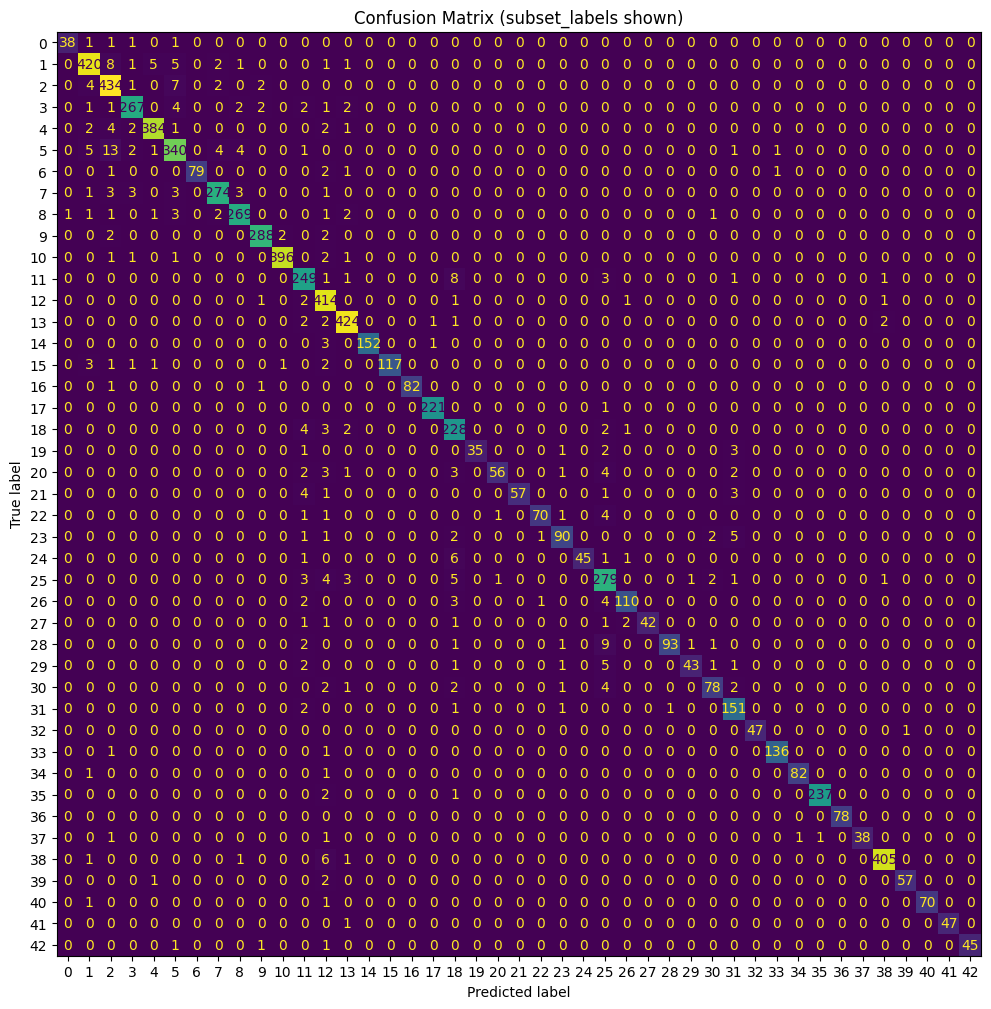

Number of misclassified samples: 375
Index 10: true=30, pred=25
Index 47: true=21, pred=25
Index 77: true=30, pred=25
Index 78: true=1, pred=2
Index 80: true=5, pred=31
Index 91: true=12, pred=38
Index 179: true=28, pred=25
Index 210: true=29, pred=31
Index 225: true=25, pred=18
Index 229: true=1, pred=4
Index 239: true=2, pred=1
Index 258: true=15, pred=12


In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax, cmap='viridis', colorbar=False)
plt.title('Confusion Matrix (subset_labels shown)')
plt.show()

# Show some misclassified examples
mis_idx = np.where(y_test != y_pred)[0]
print('Number of misclassified samples:', len(mis_idx))
for i in mis_idx[:12]:
    # sample_feat = X_test[i]
    print(f'Index {i}: true={y_test[i]}, pred={y_pred[i]}')


## Save the trained model

Very big dataset; takes too much time to train again and again


In [ ]:
if save_model:
    joblib.dump(clf, model_path)
    print('Saved model to', model_path)

Saved model to svm_hog_gtsrb_rbf_c60_itr2.joblib


## Predict using saved model


In [ ]:
def load_model(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f'Model file not found: {path}')
    model = joblib.load(path)
    return model

In [ ]:
if load_model_and_predict:
    clf = load_model(model_path_load)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Test Accuracy:', acc)
    print('\nClassification report:')
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    fig, ax = plt.subplots(figsize=(12,12))
    disp.plot(ax=ax, cmap='viridis', colorbar=False)
    plt.title('Confusion Matrix (subset_labels shown)')
    plt.show()

    # Show some misclassified examples
    mis_idx = np.where(y_test != y_pred)[0]
    print('Number of misclassified samples:', len(mis_idx))
    for i in mis_idx[:12]:
        print(f'Index {i}: true={y_test[i]}, pred={y_pred[i]}')